### 라이브러리 임포트

In [1]:
%cd /content/drive/MyDrive/colab/deep_learning_basic/처음_시작하는_딥러닝

/content/drive/MyDrive/colab/deep_learning_basic/처음_시작하는_딥러닝


In [38]:
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.pytorch.layers import PyTorchLayer, DenseLayer
from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor
from lincoln.pytorch.utils import assert_dim, permute_data

In [3]:
%load_ext autoreload
%autoreload 2

## 파이토치로 딥러닝 구현하기

- 각종 Layer 객체를 포함하는 Model 객체
- 최적화를 담당하는 Optimiaer 객체
- 손실 계산을 담당하는 Loss 객체
- 학습을 실제로 진행하는 Trainer 객체

PyTorchLayer

In [4]:
from torch import nn, Tensor

class PyTorchLayer(nn.Module):

  def __init__(self) -> None:
    super().__init__()

  def forward(self, x: Tensor,
              inference: bool = False) -> Tensor:
    raise NotImplementedError()

PyTorchModel

In [5]:
class PyTorchModel(nn.Module):

  def __init__(self) -> None:
    super().__init__()

  def forward(self, x: Tensor,
              inference: bool = False) -> Tensor:
    raise NotImplementedError()

DenseLayer 클래스

In [23]:
class DenseLayer(PyTorchLayer):
  def __init__(self,
               input_size: int,
               neurons: int,
               dropout: float = 1.0,
               activation: nn.Module = None) -> None:
    super().__init__()
    self.linear = nn.Linear(input_size, neurons)
    self.activation = activation
    if dropout < 1.0:
      self.dropout = nn.Dropout(1 - dropout)
      
  def forward(self, x: Tensor,
              inference: bool = False) -> Tensor:
    if inference:
      self.apply(inference_mode)

    x = self.linear(x)      # 가중치를 곱하고 편향을 더함
    if self.activation:
      x = self.activation(x)
    if hasattr(self, 'dropout'):
      x = self.dropout(x)

    return x

### 주택가격 데이터셋

In [7]:
from sklearn.datasets import load_boston

boston = load_boston()

data = boston.data
target = boston.target
features = boston.feature_names

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=220123)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

#### 주택가격 예측 모델 정의

In [8]:
class HousePricesModel(PyTorchModel):

  def __init__(self,
               hidden_size: int = 13,
               hidden_dropout: float = 1.0):
    super().__init__()
    self.dense1 = DenseLayer(13, hidden_size,
                             activation = nn.Sigmoid(),
                             dropout = hidden_dropout)
    self.dense2 = DenseLayer(hidden_size, 1)

  def forward(self, x: Tensor) -> Tensor:

    assert_dim(x, 2)
    
    assert x.shape[1] == 13

    x = self.dense1(x)
    return self.dense2(x)

In [9]:
pytorch_boston_model = HousePricesModel(hidden_size = 13)

In [10]:
class HousePricesModel(PyTorchModel):

  def __init__(self,
               hidden_size: int = 13):
    super().__init__()
    self.fc1 = nn.Linear(13,hidden_size)
    self.fc2 = nn.Linear(hidden_size, 1)

  def forward(self, x: Tensor) -> Tensor:

    assert_dim(x, 2)
    
    assert x.shape[1] == 13

    x = self.fc1(x)
    x = torch.sigmoid(x)
    return self.fc2(x)

#### Optimizer와 Loss 클래스

In [11]:
import torch.optim as optim

optimizer = optim.SGD(pytorch_boston_model.parameters(), lr = 0.001)

In [12]:
mean_squared_error_loss = nn.MSELoss()
softmax_cross_entropy_loss = nn.CrossEntropyLoss()

#### Trainer 클래스

[Trainer 클래스가 갖춰야 할 조건]

1. 학습 데이터 중 1개의 배치를 모델에서 입력한다.
2. 모델의 출력값과 목표값을 손실함수에 입력해 손실을 계산한다.
3. 파라미터에 대한 손실의 기울기를 계산한다.
4. Optimizer 객체를 이용해 주어진 규칙에 따라 파라미터를 수정한다.

<br/>

[파이토치를 사용한 학습 과정 시 차이점]

1. 기본적으로 Optimizer는 파라미터가 수정된 후에도 앞서 계산된 파라미터 기울기값(앞에서 pram_grads라고 불렀던 값)을 그대로 남겨둔다. 이 값을 삭제하려면 self.optim.zero_grad를 호출한다.
2. 앞서 직접 구현한 간단한 자동 미분과 마찬가지로 역전파를 시작하려면 손실을 계산한 다음, loss.backward를 직접 호출한다.

PyTorchTrainer

In [13]:
class PyTorchTrainer(object):
  def __init__(self, 
               model: PyTorchModel,
               optim: Optimizer,
               criterion: _Loss):
    self.model = model
    self.optim = optim
    self.loss = criterion
    self._check_optim_net_aligned()

  def _check_optim_net_aligned(self):
    assert self.optim.param_groups[0]['params'] == list(self.model.parameters())

  def _generate_batches(self,
                        X: Tensor,
                        y: Tensor,
                        size: int = 32) -> Tuple[Tensor]:
    N = X.shape[0]

    for ii in range(0, N, size):
      X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

      yield X_batch, y_batch

  def fit(self, X_train: Tensor, y_train: Tensor,
          X_test: Tensor, y_test: Tensor,
          epochs: int = 100,
          eval_every: int = 10,
          batch_size: int = 32):
    
    for e in range(epochs):
      X_train, y_train = permute_data(X_train, y_train)
    
      batch_generator = self._generate_batches(X_train, y_train, batch_size)

      for ii, (X_batch, y_batch) in enumerate(batch_generator):

        self.optim.zero_grad()
        output = self.model(X_batch)
        loss = self.loss(output, y_batch)
        loss.backward()
        self.optim.step()

      output = self.model(X_test)
      loss = self.loss(output, y_test)
      print(e, loss)

In [14]:
net = HousePricesModel()
optimizer = optim.SGD(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

trainer = PyTorchTrainer(net, optimizer, criterion)

trainer.fit(X_train, y_train, X_test, y_test,
            epochs = 10,
            eval_every = 1)

0 tensor(494.1219, grad_fn=<MseLossBackward0>)
1 tensor(410.5645, grad_fn=<MseLossBackward0>)
2 tensor(334.1960, grad_fn=<MseLossBackward0>)
3 tensor(270.6062, grad_fn=<MseLossBackward0>)
4 tensor(213.1607, grad_fn=<MseLossBackward0>)
5 tensor(169.4891, grad_fn=<MseLossBackward0>)
6 tensor(135.0083, grad_fn=<MseLossBackward0>)
7 tensor(107.4790, grad_fn=<MseLossBackward0>)
8 tensor(88.3298, grad_fn=<MseLossBackward0>)
9 tensor(70.0321, grad_fn=<MseLossBackward0>)


#### 학습 최적화 기법
- 모멘텀
- 드롭아웃
- 가중치 초기화
- 학습률 감쇠

## 합성곱 신경망 구현하기

- 이 연산은 각 뉴런이 입력 이미지 내 뉴런이 대응하는 위치에 어떤 시각적패턴(시각적 패턴은 합성곱 필터에 의해 정의된다)의 존재 유무를 나타내도록 조직된 뉴런의 특징 맵의 형태로 입력 이미지를 변환한다.
- 다 채널 합성곱 연산은 다음과 같은 모양의 두 가지 입력과 한 가지 출력을 갖는다.
  - 모양이 [batch_size, in_channels, image_height]인 데이터 입력
  - 모양이 [in_channels, out_channels, filter_size, filter_size]인 파라미터 입력
  - 모양이 [batch_size, out_channels, image_height, image_width]인 출력

- 파이토치에 구현된 다채널 합성곱 연산의 시그니처는 다음과 같이 나타낼 수 있다.

```
nn.Conv2d(in_channels, out_channels, filter_size)
```

ConvLayer 클래스

In [15]:
class ConvLayer(PyTorchLayer):
  def __init__(self,
               in_channels: int,
               out_channels: int,
               filter_size: int,
               activation: nn.Module = None,
               flatten: bool = False,
               dropout: float = 1.0) -> None:
    super().__init__()

    # 실제 연산
    self.conv = nn.Conv2d(in_channels, out_channels, filter_size, padding = filter_size // 2)

    # activation과 flatten은 이전의 것을 그대로 사용
    self.activation = activation
    self.flatten = flatten
    if dropout < 1.0:
      self.dropout = nn.Dropout(1 - dropout)

  def forward(self, x: Tensor) -> Tensor:

    # 합성곱 연산은 항상 수행
    x = self.conv(x)

    # 필요에 따라 수행하는 연산
    if self.activation:
      x = self.activation(x)
    if self.flatten:
      x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
    if hasattr(self, 'dropout'):
      x = self.dropout(x)

    return x

MNIST_ConvNet 클래스

In [16]:
class MNIST_ConvNet(PyTorchModel):
  def __init__(self):
    super().__init__()
    self.conv1 = ConvLayer(1, 16, 5, activation = nn.Tanh(), dropout = 0.8)
    self.conv2 = ConvLayer(16, 8, 5, activation = nn.Tanh(), flatten = True, dropout = 0.8)

    self.dense1 = DenseLayer(28 * 28 * 8, 32, activation = nn.Tanh(),
                             dropout = 0.8)
    self.dense2 = DenseLayer(32, 10)

  def forward(self, x: Tensor) -> Tensor:
    assert_dim(x, 4)

    x = self.conv1(x)
    x = self.conv2(x)

    x = self.dense1(x)
    x = self.dense2(x)

    return x

학습 전 데이터 전처리

In [19]:
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])

In [20]:
train_dataset = MNIST(root='../mnist_data/',
                      train=True, 
                      download=True,
                      transform=img_transforms)

test_dataset = MNIST(root='../mnist_data/',
                     train=False, 
                     download=True,
                     transform=img_transforms)

In [21]:
mnist_train = ((train_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_test = ((test_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_train.min(), mnist_train.max(), mnist_test.min(), mnist_test.max()

(tensor(-0.4236), tensor(2.8221), tensor(-0.4236), tensor(2.8221))

모델 학습

In [24]:
model = MNIST_ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(mnist_train, train_dataset.targets,
            mnist_test, test_dataset.targets,
            epochs = 5,
            eval_every = 1)

0 tensor(0.1435, grad_fn=<NllLossBackward0>)
1 tensor(0.1424, grad_fn=<NllLossBackward0>)
2 tensor(0.1117, grad_fn=<NllLossBackward0>)
3 tensor(0.1058, grad_fn=<NllLossBackward0>)
4 tensor(0.1202, grad_fn=<NllLossBackward0>)


#### DataLoader와 데이터 변환

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=60, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=60,
                                          shuffle = False)

In [26]:
trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train=mnist_train, y_train=train_dataset.targets, 
            X_test=mnist_test, y_test=test_dataset.targets,     
            epochs=1,
            eval_every=1)

0 tensor(0.1028, grad_fn=<NllLossBackward0>)


#### LSTM 구현하기

In [27]:
class LSTMLayer(PyTorchLayer):
  def __init__(self,
               sequence_length: int,
               input_size: int,
               hidden_size: int,
               output_size: int,
               dropout: float = 1.0) -> None:
    super().__init__()
    self.hidden_size = hidden_size
    self.h_init = torch.zeros((1, hidden_size))
    self.c_init = torch.zeros((1, hidden_size))
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = DenseLayer(hidden_size, output_size)
    if dropout < 1.0:
      self.dropout = nn.Dropout(1 - dropout)

  def _transform_hidden_batch(self, hidden: Tensor,
                              batch_size: int,
                              before_layer: bool) -> Tensor:
    if before_layer:
      return (hidden.repeat(batch_size, 1)
      .view(batch_size, 1, self.hidden_size)
      .permute(1, 0, 2))

    else:
      return (hidden.permute(1, 0, 2).mean(dim = 0))

  def forward(self, x: Tensor) -> Tensor:

    batch_size = x.shape[0]
    
    h_layer = self._transform_hidden_batch(self.h_init, batch_size, before_layer = True)
    c_layer = self._transform_hidden_batch(self.c_init, batch_size, before_layer = True)

    x, (h_out, c_out) = self.lstm(x, (h_layer, c_layer))

    self.h_init, self.c_init = (
        self._transform_hidden_batch(h_out, batch_size, before_layer = False).detach(),
        self._transform_hidden_batch(c_out, batch_size, before_layer = False).detach()
    )

    x = self.fc(x)
    if hasattr(self, 'dropout'):
      x = self.dropout(x)

    return x

NextCharacterModel

In [28]:
class NextCharacterModel(PyTorchModel):
  def __init__(self,
               vocab_size: int,
               hidden_size: int = 256,
               sequence_length: int = 25):
    super().__init__()
    self.vocab_size = vocab_size
    self.sequence_length = sequence_length

    # 이 모델에는 층이 하나뿐이며
    # 이 층의 출력은 입력과 모양이 같다.
    self.lstm = LSTMLayer(self.sequence_length,
                          self.vocab_size,
                          hidden_size,
                          self.vocab_size)
    
  def forward(self,
              inputs: Tensor):
    assert_dim(inputs, 3)     # batch_size, sequence_length, vocab_size

    out = self.lstm(inputs)

    return out.permute(0, 2, 1)

LSTMTrainer

In [29]:
class LSTMTrainer(PyTorchTrainer):
    def __init__(self,
                 model: NextCharacterModel,
                 optim: Optimizer,
                 criterion: _Loss):
        super().__init__(model, optim, criterion)
        self.vocab_size = self.model.vocab_size
        self.max_len = self.model.sequence_length
        
    def fit(self,
            data: str,
            epochs: int=10,
            eval_every: int=1,
            batch_size: int=32,
            seed: int = 121718)-> None:
        
        self.data = data
        self.train_data, self.test_data = self._train_test_split_text()
        self.chars = list(set(self.data))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        torch.manual_seed(seed)

        losses = deque(maxlen=50)
        
        for e in range(epochs):

            batch_generator = self.generate_batches_next_char(batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.optim.zero_grad()                
                outputs = self.model(X_batch)[0]

                loss = self.loss(outputs, y_batch)
                losses.append(loss.item())

                loss.backward()
                
                self.optim.step()    

            if (e+1) % eval_every == 0:

                X_test, y_test = self.generate_test_data()
            
                test_preds = self.model.forward(X_test)[0]

                loss = self.loss.forward(test_preds, y_test)
                print(f"{e+1}에폭에서 검증 데이터에 대한 손실값: {loss.item():.3f}")

    def _train_test_split_text(self, pct=0.8) -> Tuple[str]:

        n = len(self.data)
        return self.data[:int(n * pct)], self.data[int(n * pct):]

    def generate_batches_next_char(self,
                                   batch_size: int) -> Tuple[Tensor]:
        N = len(self.train_data)
        # add batch size
        for ii in range(0, N, batch_size):

            features_tensors = []
            target_indices = []

            for char in range(batch_size):

                features_str, target_str =\
                 self.train_data[ii+char:ii+char+self.max_len],\
                 self.train_data[ii+char+1:ii+char+self.max_len+1]

                features_array = self._string_to_one_hot_array(features_str)
                target_indices_seq = [self.char_to_idx[char] for char in target_str]

                features_tensors.append(features_array)
                target_indices.append(target_indices_seq)
            if len(features_str) != len(target_str):
                break
            yield torch.stack(features_tensors), torch.LongTensor(target_indices)

    def _string_to_one_hot_array(self, input_string: str) -> Tuple[Tensor]:

        ind = [self.char_to_idx[ch] for ch in input_string]

        array = self._one_hot_text_data(ind)

        return array

    def _one_hot_text_data(self,
                           sequence: List):

        sequence_length = len(sequence)
        batch = torch.zeros(sequence_length, self.vocab_size)
        for i in range(sequence_length):
            batch[i, sequence[i]] = 1.0

        return Tensor(batch)

    def generate_test_data(self) -> Tuple[Tensor]:

        features_str, target_str = self.test_data[:-1], self.test_data[1:]

        X_tensors = []
        y_tensors = []

        N = len(self.test_data)

        for start in range(0, N, self.max_len):

            features_str, target_str =\
                self.test_data[start:start+self.max_len],\
                self.test_data[start+1:start+self.max_len+1]

            if len(features_str) != len(target_str):
                break
            features_array = self._string_to_one_hot_array(features_str)
            target_indices_seq = [self.char_to_idx[char] for char in target_str]

            X_tensors.append(features_array)
            y_tensors.append(torch.LongTensor(target_indices_seq))
            
        return torch.stack(X_tensors), torch.stack(y_tensors)

In [30]:
data = open('input.txt', 'r').read()
vocab_size = len(set(data))
model = NextCharacterModel(vocab_size, hidden_size=vocab_size, sequence_length=50)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

In [31]:
lstm_trainer = LSTMTrainer(model, optimizer, criterion)

In [ ]:
lstm_trainer.fit(data, epochs = 1)

## 오토인코더를 활용한 비지도 학습

#### 오토인코더 구현하기

In [47]:
class Encoder(PyTorchModel):
  def __init__(self, hidden_dim: int = 28):
    super(Encoder, self).__init__()
    self.conv1 = ConvLayer(1, 14, 5, activation = nn.Tanh())
    self.conv2 = ConvLayer(14, 7, 5, activation = nn.Tanh(), flatten = True)

    self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation = nn.Tanh())

  def forward(self, x: Tensor) -> Tensor:
    assert_dim(x, 4)

    x = self.conv1(x)
    x = self.conv2(x)
    x = self.dense1(x)

    return x

In [52]:
class Decoder(PyTorchModel):
  def __init__(self, hidden_dim: int = 28):
    super(Decoder, self).__init__()
    self.dense1= DenseLayer(hidden_dim, 7 * 28 * 28, activation = nn.Tanh())

    self.conv1 = ConvLayer(7, 14, 5,  activation = nn.Tanh())
    self.conv2 = ConvLayer(14, 1, 5,activation = nn.Tanh())

  def forward(self, x: Tensor) -> Tensor:
    assert_dim(x, 2)

    x = self.dense1(x)

    x = x.view(-1, 7, 28, 28)
    x = self.conv1(x)
    x = self.conv2(x)

    return x

Autoencoder

In [49]:
class Autoencoder(PyTorchModel):
  def __init__(self,
               hidden_dim: int = 28):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(hidden_dim)

    self.decoder = Decoder(hidden_dim)

  def forward(self, x: Tensor) -> Tensor:
    assert_dim(x, 4)

    encoding = self.encoder(x)
    x = self.decoder(encoding)

    return x, encoding

데이터 전처리

In [37]:
X_train = mnist_train
X_test = mnist_test

In [39]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [53]:
model = Autoencoder(hidden_dim=28)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=1,
            batch_size=60)

1  에폭 학습한 후의 손실은  0.07153086364269257


In [54]:
reconstructed_images, image_representations = model(X_test_auto)

In [55]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

In [56]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

In [57]:
np.random.seed(20220123)
a = np.random.randint(0, 10000)

In [58]:
X_test[a].shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

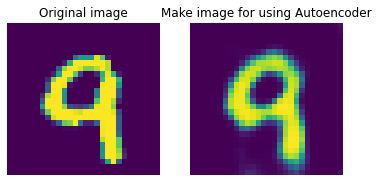

In [60]:
f, axarr = plt.subplots(1, 2)
display_image(axarr[0], X_test[a])
display_image(axarr[1], reconstructed_images[a])

axarr[0].set_title('Original image')
axarr[1].set_title('Make image for using Autoencoder')

axarr[0].axis('off')
axarr[1].axis('off')

#### t-SNE를 이용한 시각화

- t-분포 확률정 임베딩(t-Distributed Stochastic Neighbor Embeddint)
- 초기 저차원 표현으로 시작해 저차원 공간 내에서 비슷한 위치에 매핑되는 데이터가 고차원 공간에서도 비슷한 위치에 매핑되도록, 그리고 그 반대도 성립하도록 이 저차원 표현을 반복적으로 수정해나가는 기법

In [62]:
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components = 2, random_state = 20220123).fit_transform(image_representations.detach().numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


시각화

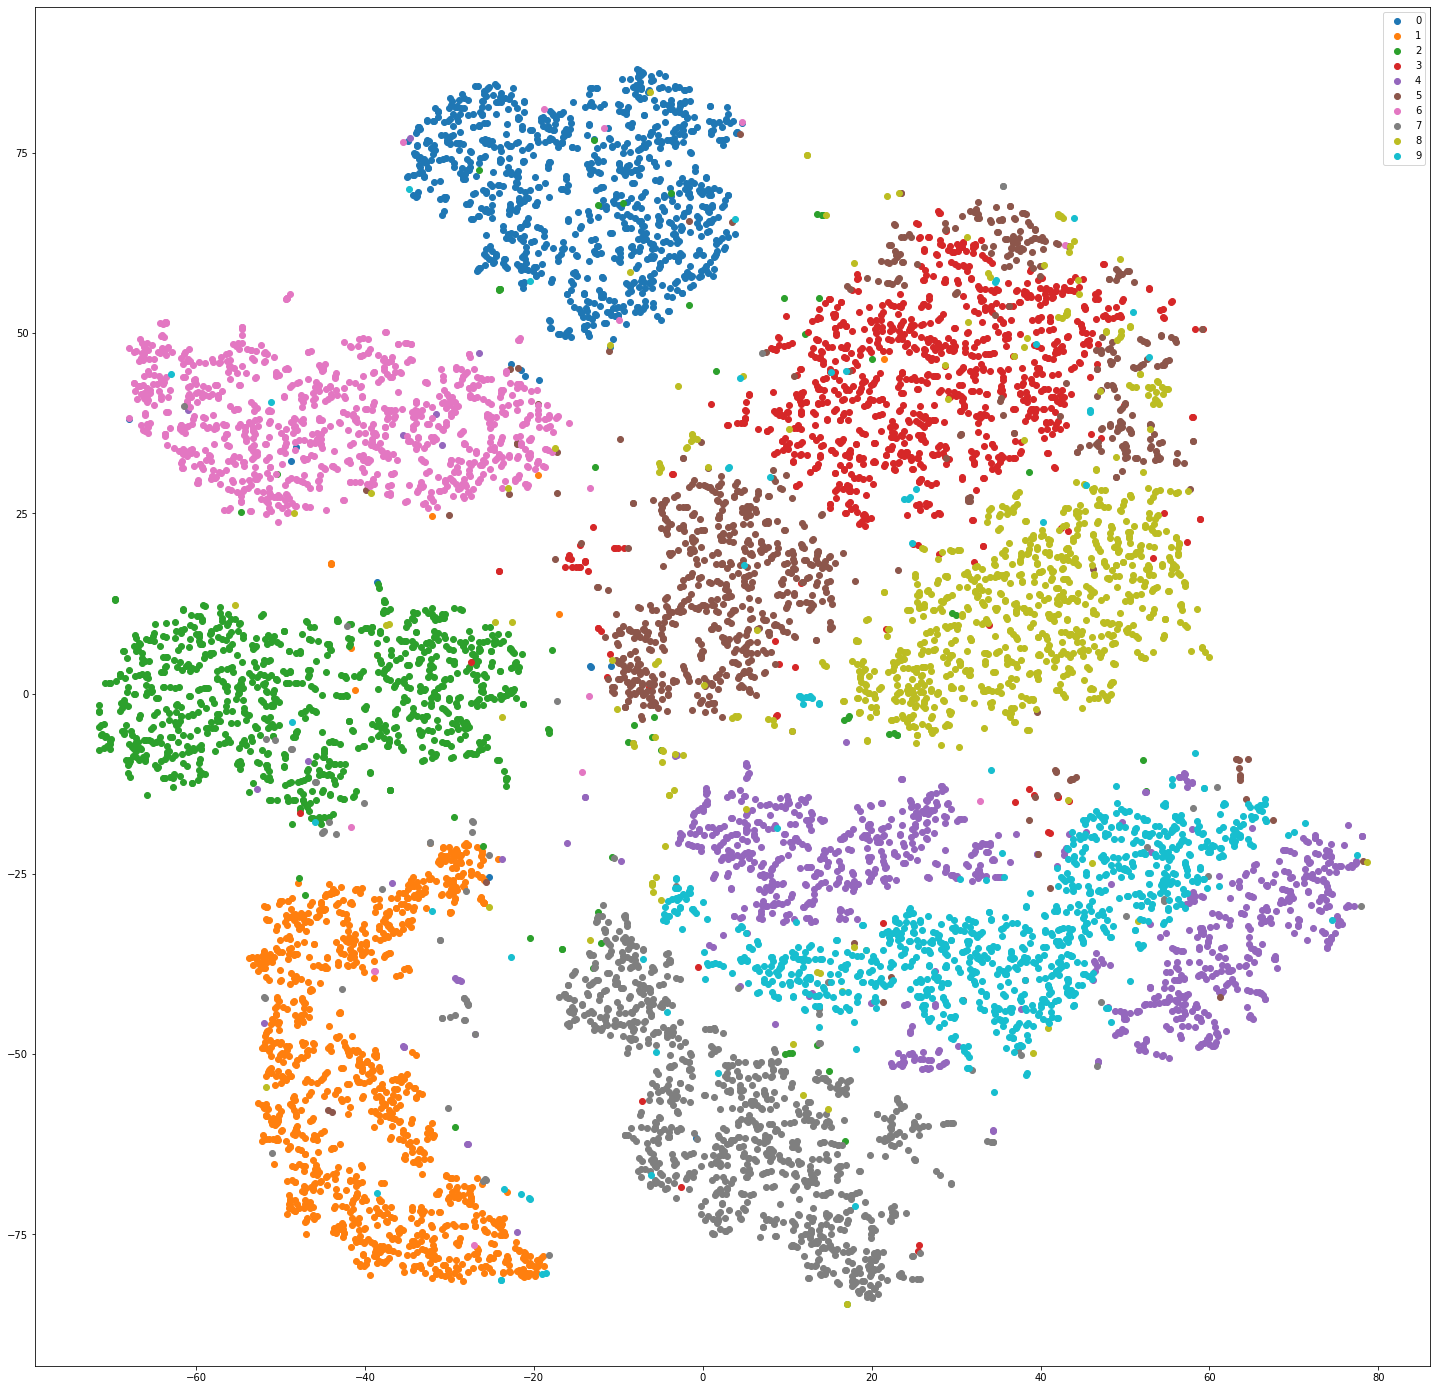

In [64]:
'''MNIST 데이터 집합 중 테스트 집합의 10000개 관찰을 대상으로 한다. 
색은 해당 관찰이 어떤 숫자를 쓴 것인지 가리키며 
위치는 합성곱 오토인코더로 압축된 28차원값을 재차 t-SNE로 차원축소한 결과다.'''
import pandas as pd
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0],
                        'tsne_dim_2': tsne_result[:, 1],
                        'category': test_dataset.targets})

groups = tsne_df.groupby('category')

fig, ax = plt.subplots(figsize = (25, 25))
ax.margins(0.05) # 자동 스케일링을 위한 5% 패딩 추가
for name, group in groups:
  ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker = 'o', label = name)

ax.legend()